# **PyTorch Workflow**

**What we're going to cover:**
 - **Getting data ready**
    - **`torch.utils.data.Dataset`**
    - **`torch.utils.data.DataLoader`**
 - **Building a model**
    - **`torch.nn`**
    - **`torch.nn.Module`**
    - **`torch.nn.Parameter`**
    - **`torchvision.models`**
    - **`torch.optim`**
 - **Fitting the model to data (training)**
 - **Making predictions and evaluating a model (inference)**
    - **`torchmetrics`**
 - **Improving through experimentation**
    - **`torch.utils.tensorboard`**
 - **Saving and loading a model**

## **Imports**

In [1]:
# Imports
import torch
from torch import nn # Contaings building blocks for neural network

from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

In [2]:
# Check PyTorch version
torch.__version__

'2.0.1+cu118'

## **Device Agnostic Setting**

In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## **Data Preparation and Loading**

In [4]:
# Set random seed for reproducible code
torch.manual_seed(42)
np.random.seed(42)

In [5]:
# Number of samples to generate
num_samples = 20_000

# Initialize the value for weight (slope) and bias (y-intercept)
weight = 2.5
bias = 5.0

# Random error control parameter
random_error_scale = 0.5

In [6]:
# Generate random input data between -1 and 1
X = torch.linspace(-1, 1, num_samples).unsqueeze(dim = 1)

# Generate random error
random_error = torch.randn(num_samples, 1) * random_error_scale

# Generate the target (output) with the random error
y = weight * X + bias + random_error

In [7]:
# View sampels from X and y
print("Input Samples: \n", X[:5])
print("Output Samples: \n", y[:5])

Input Samples: 
 tensor([[-1.0000],
        [-0.9999],
        [-0.9998],
        [-0.9997],
        [-0.9996]])
Output Samples: 
 tensor([[3.4635],
        [3.2439],
        [2.9509],
        [1.4480],
        [2.8402]])


### **Split into Train and Test Set**

In [8]:
# Make training and testing data from the complete data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size = 0.8, shuffle = True, random_state = 42
)

# Print the shape of the data
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([16000, 1]),
 torch.Size([4000, 1]),
 torch.Size([16000, 1]),
 torch.Size([4000, 1]))

### **Plot Data**

In [9]:
# Declare the function to plot the data
def plot_data(train_data = X_train,
              train_labels = y_train,
              test_data = X_test,
              test_labels = y_test,
              predictions = None):
    """
    Plots the training data, testing data and compares predictions.
    """

    # Configure the plot size
    plt.figure(figsize = (8, 5))

    # Plot the training data
    plt.scatter(
        x = train_data,
        y = train_labels,
        c = "blue",
        s = 16,
        label = "Training Data"
    )


    # Plot the testing data
    plt.scatter(
        x = test_data,
        y = test_labels,
        c = "green",
        s = 16,
        label = "Testing Data"
    )

    # If predictions exist
    if predictions is not None:
        # Plot the testing data
        plt.scatter(
            x = test_data,
            y = predictions,
            c = "red",
            s = 16,
            label = "Predictions"
        )

    # Add labels
    plt.xlabel("Features")
    plt.ylabel("Target")

    # Show the legned
    plt.legend(prop = {"size": 10});

    # Add the title
    plt.title("Visualize the Data")

    # Show the plot
    plt.show()

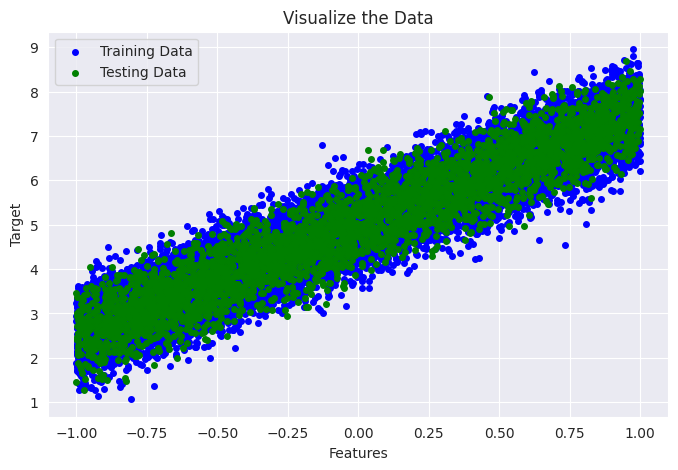

In [10]:
# Call the function
plot_data(X_train, y_train, X_test, y_test)

## **Building Model**

In [11]:
# Create a linear regression model in PyTorch
class LinearRegressionModelV2(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        # Use nn.Linear() for creating model parameters
        self.linear_layer = nn.Linear(in_features = 1, out_features = 1)

    # Define forward() computation
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

### **Model Contents**

In [12]:
# Create a random seed
torch.manual_seed(42)

In [13]:
# Create instance of model
lrm_v2 = LinearRegressionModelV2()
lrm_v2

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [14]:
# View the model parameters
list(lrm_v2.parameters())

[Parameter containing:
 tensor([[0.7645]], requires_grad=True),
 Parameter containing:
 tensor([0.8300], requires_grad=True)]

In [15]:
# List named parameters
lrm_v2.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
             ('linear_layer.bias', tensor([0.8300]))])

### **Move Model to GPU**

In [16]:
# Check model device
next(lrm_v2.parameters()).device

device(type='cpu')

In [17]:
# Set model to GPU if it's availalble, otherwise it'll default to CPU
lrm_v2.to(device)
next(lrm_v2.parameters()).device

device(type='cuda', index=0)

## **Model Training**
**Things required for training:**
 - **Loss Function**
 - **Optimizer**

### **Loss Function and Optimizer**

In [18]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer to optimize the model parameters
optimizer = torch.optim.SGD(params = lrm_v2.parameters(), lr = 1e-2)

### **Training and Testing Loop**

**Training Loop Requirements:**
 - **Set training mode**
 - **Forward pass**
 - **Calculate the loss**
 - **Optimizer zero grad**
 - **Loss backward `Backpropagation`**
 - **Optimizer step `Gradient Descent`**

In [19]:
# Random seed for reproducible outputs
torch.manual_seed(42)

# Initialize epochs (training iterations)
epochs = 1_000

# Setup empty lists to track model progress
train_loss_values = []
test_loss_values = []
epoch_count = []

# Move tensors to the device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

# Loop through the data
for epoch in range(epochs):
    # Training

    ## Set the model to training mode
    lrm_v2.train()

    ## Forward pass
    train_pred = lrm_v2(X_train)

    ## Calculate the loss
    train_loss = loss_fn(train_pred, y_train)

    ## Optimizer zero grad
    optimizer.zero_grad()

    ## Perform backpropagation
    train_loss.backward()

    ## Step the optimizer
    optimizer.step()

    # Testing

    ## Set the model to evaluation mode
    lrm_v2.eval()

    ## Use inference mode for faster predictions
    with torch.inference_mode():
        ## Forward pass
        test_pred = lrm_v2(X_test)

        ## Calculate the loss
        test_loss = loss_fn(test_pred, y_test.type(torch.float))

    ## For every epochs track the progress
    if epoch % (epochs // 10) == 0:
        ## Update the lists
        epoch_count.append(epoch)
        train_loss_values.append(train_loss.cpu().detach().numpy())
        test_loss_values.append(test_loss.cpu().detach().numpy())

        ## Print the progress
        print(f"Epoch: {epoch}\t| MAE Train Loss: {train_loss:.4f} | MAE Test Loss: {test_loss:.4f}")

Epoch: 0	| MAE Train Loss: 4.1765 | MAE Test Loss: 4.1567
Epoch: 100	| MAE Train Loss: 3.1765 | MAE Test Loss: 3.1567
Epoch: 200	| MAE Train Loss: 2.1895 | MAE Test Loss: 2.1701
Epoch: 300	| MAE Train Loss: 1.4043 | MAE Test Loss: 1.3854
Epoch: 400	| MAE Train Loss: 0.9481 | MAE Test Loss: 0.9306
Epoch: 500	| MAE Train Loss: 0.6779 | MAE Test Loss: 0.6654
Epoch: 600	| MAE Train Loss: 0.5227 | MAE Test Loss: 0.5180
Epoch: 700	| MAE Train Loss: 0.4488 | MAE Test Loss: 0.4448
Epoch: 800	| MAE Train Loss: 0.4189 | MAE Test Loss: 0.4138
Epoch: 900	| MAE Train Loss: 0.4076 | MAE Test Loss: 0.4022


### **Plot Loss Curves**

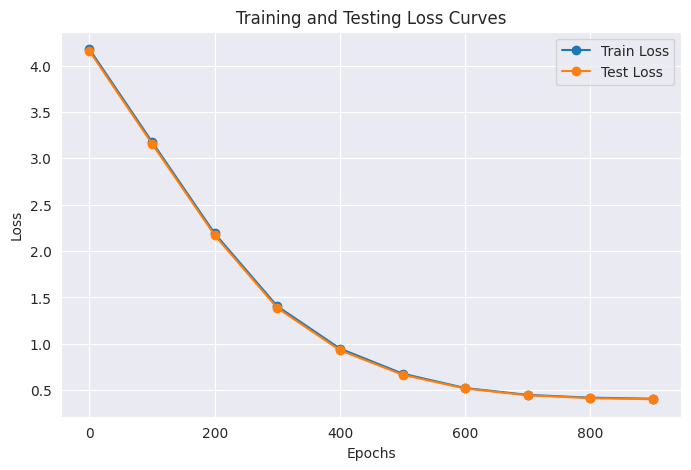

In [20]:
# Plot loss curves
plt.figure(figsize = (8, 5))
plt.plot(epoch_count, train_loss_values, label = "Train Loss", marker = "o")
plt.plot(epoch_count, test_loss_values, label = "Test Loss", marker = "o")
plt.title("Training and Testing Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

### **Learned Parameters**

In [21]:
# Print the models learned paraemters
print("Original Parameter Values:")
print(f"weight = {weight}, bias = {bias}")

print("\nLearned Parameter Values:")
print(lrm_v2.state_dict())

Original Parameter Values:
weight = 2.5, bias = 5.0

Learned Parameter Values:
OrderedDict([('linear_layer.weight', tensor([[2.4132]], device='cuda:0')), ('linear_layer.bias', tensor([5.0086], device='cuda:0'))])


### **Making Predictions**

In [22]:
# Turn model into evaluation mode
lrm_v2.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = lrm_v2(X_test)

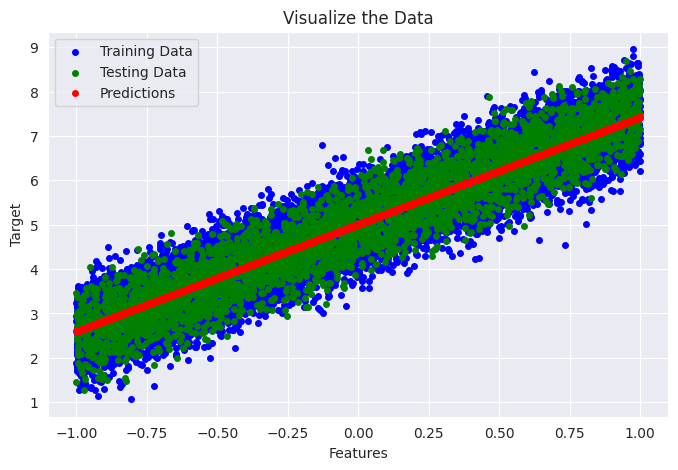

In [23]:
# Plotting predictions
plot_data(X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu(), y_preds.cpu())

## **Saving a Model**

In [24]:
# Mount google drive
from google.colab import drive
drive.mount("./Drive", force_remount = True)

Mounted at ./Drive


In [25]:
# Create models directory
MODEL_PATH = Path("./Drive/MyDrive/PyTorch Course/models")
MODEL_PATH.mkdir(parents = True, exist_ok = True)

# Create model save path
MODEL_NAME = "01_pytorch_workflow_linear_regression_v2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving Model to: {MODEL_SAVE_PATH}")
torch.save(obj = lrm_v2.state_dict(), f = MODEL_SAVE_PATH)

Saving Model to: Drive/MyDrive/PyTorch Course/models/01_pytorch_workflow_linear_regression_v2.pth


In [26]:
# Check the saved file path
!ls -l "./Drive/MyDrive/PyTorch Course/models/01_pytorch_workflow_linear_regression_v2.pth"

-rw------- 1 root root 1387 Jul 18 14:51 './Drive/MyDrive/PyTorch Course/models/01_pytorch_workflow_linear_regression_v2.pth'


## **Loading a Model**

In [27]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_lrm_v2 = LinearRegressionModelV2()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_lrm_v2.load_state_dict(torch.load(f = MODEL_SAVE_PATH))

# Put the model on the device
loaded_lrm_v2.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [28]:
# Put the loaded model into evaluation mode
loaded_lrm_v2.eval()

# Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_lrm_v2(X_test.to(device))

In [29]:
# Compare previous model predictions with loaded model predictions (these should be the same)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        ...,
        [True],
        [True],
        [True]], device='cuda:0')